In [1]:
import pandas as pd
import xgboost
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Load Data

In [2]:
df = pd.read_csv('../../data/interim/full_joined_data.csv', index_col=0)
df.head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
0,410050201001000,998326755,1.548381,3.355589,236771176,1.716985,3.834511,731023672,1.776342,3.778623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,410050201001001,998326755,1.358351,2.816526,236771176,1.526954,3.295449,731023672,1.586312,3.239560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,410050201001002,998326755,1.683183,3.781076,236771176,1.851786,4.259999,731023672,1.911143,4.204111,...,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,27.0
3,410050201001003,998326755,1.480122,3.140135,236771176,1.648726,3.619058,731023672,1.708083,3.563170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,410050201001004,998326755,1.577137,2.642447,236771176,1.745741,3.121370,731023672,1.805098,3.065482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


## Select Features
We only select the promities, the store IDs and the enrichment variables

In [3]:
feature_list = df.columns.tolist()
_ = feature_list.index('groupquarters_gqpop_cy')
enrichment_variables = feature_list[_:]
other_variables = [f for f in feature_list[:_] if '_id' not in f and 'trip_count' not in f]
other_variables = list(set(other_variables) - {'Unnamed: 0'})

In [4]:
enrichment_variables[:5]

['groupquarters_gqpop_cy',
 'generations_genalphacy',
 'generations_genz_cy',
 'generations_millenn_cy',
 'generations_genx_cy']

In [5]:
other_variables[:5]

['store_name_category_03_STARBUCKS',
 'store_name_category_02_AVA_ROASTERIA',
 'store_name_category_04_COFFEE_RUSH',
 'proximity_kilometers_01',
 'store_name_category_04_STARBUCKS']

In [6]:
# All feature columns
features = other_variables + enrichment_variables

In [7]:
# Pearson correlation between variables
from scipy.stats import pearsonr
R = np.array([pearsonr(df.loc[:,'trip_count_01'] ,df.loc[:,c])[0] for c in enrichment_variables])

In [8]:
idx = np.argsort(R)
print(np.sort(R)[::-1][:50])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


We see a lot of correlations, nothing other ~22%. It'll have to be the combination that gives any reasonable preditive power

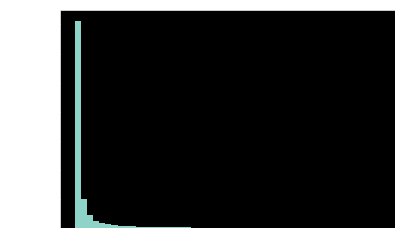

In [9]:
df.trip_count_01.plot.hist(range(51))

In [10]:
df.loc[:,'log_trip_count'] = np.log10(df.trip_count_01 + 1)

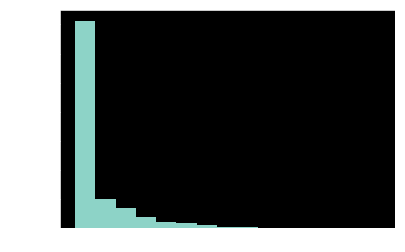

In [11]:
df.log_trip_count.plot.hist(15)

By far, the majority are zeros. Since most blocks DON'T visit a coffee shop, it makes sense to look at this initially as a binary classification problem:
Will a block visit this coffee shop?

This could potentially be done as a regression problem with the logarithm (power of ten in this case) of visits. The order of magnitude is more more useful than the exact count anyway.

In [12]:
df.trip_count_01.describe()

count    48553.000000
mean         1.610570
std         10.884486
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1616.000000
Name: trip_count_01, dtype: float64

In [13]:
df.trip_count_01.median()

0.0

The max is MUCH higher than the mean, and the median is zero. It doesn't make sense to use regression on the counts for this as the problem is framed. 

In [14]:
X = df.loc[:,features]

In [15]:
# Binary classification target
y_c = df.loc[:,'trip_count_01'].values > 0
# Log regression target
y_r = df.loc[:,'log_trip_count'].values 

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgis\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [16]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X.values, y_c, test_size=0.25, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X.values, y_r, test_size=0.25, random_state=42)

In [17]:
np.mean(y_train_c),np.mean(y_test_c)

(0.2655773719621035, 0.2664140374001153)

In [18]:
np.mean(y_train_r),np.mean(y_test_r)

(nan, 0.16547013841934952)

In [20]:
xg_c = (
    xgboost.XGBClassifier(n_estimators=1000, learning_rate=0.1)
        .fit(
            X_train_c, 
            y_train_c, 
            eval_set=[(X_test_c,y_test_c)], 
            eval_metric='auc',
            early_stopping_rounds=20
        )
)

[0]	validation_0-auc:0.771813
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.783496
[2]	validation_0-auc:0.79027
[3]	validation_0-auc:0.791272
[4]	validation_0-auc:0.791117
[5]	validation_0-auc:0.793807
[6]	validation_0-auc:0.795573
[7]	validation_0-auc:0.79656
[8]	validation_0-auc:0.798045
[9]	validation_0-auc:0.798228
[10]	validation_0-auc:0.798421
[11]	validation_0-auc:0.800001
[12]	validation_0-auc:0.800246
[13]	validation_0-auc:0.80066
[14]	validation_0-auc:0.800996
[15]	validation_0-auc:0.801338
[16]	validation_0-auc:0.804003
[17]	validation_0-auc:0.804482
[18]	validation_0-auc:0.805592
[19]	validation_0-auc:0.805602
[20]	validation_0-auc:0.805653
[21]	validation_0-auc:0.806532
[22]	validation_0-auc:0.807542
[23]	validation_0-auc:0.807604
[24]	validation_0-auc:0.808073
[25]	validation_0-auc:0.808958
[26]	validation_0-auc:0.809967
[27]	validation_0-auc:0.810247
[28]	validation_0-auc:0.810332
[29]	validation_0-auc:0.811101
[30]	validation_0-a

In [21]:
# Classification probabilities
yp_test_c = xg_c.predict_proba(X_test_c)[:,1]
yp_train_c = xg_c.predict_proba(X_train_c)[:,1]

In [24]:
yp_test_c

array([0.15670659, 0.11012024, 0.7744867 , ..., 0.4237593 , 0.5640287 ,
       0.23207477], dtype=float32)

In [25]:
print("Accuracy (Train):", accuracy_score(y_train_c, yp_train_c > 0.5))
print("Accuracy (Test):", accuracy_score(y_test_c, yp_test_c > 0.5))
print("Precision (Train):", precision_score(y_train_c, yp_train_c > 0.5))
print("Precision (Test):", precision_score(y_test_c, yp_test_c > 0.5))
print("Recall (Train):", recall_score(y_train_c, yp_train_c > 0.5))
print("Recall (Test):", recall_score(y_test_c, yp_test_c > 0.5))
print("ROC AUC (Train)", roc_auc_score(y_train_c, yp_train_c))
print("ROC AUC (Test)", roc_auc_score(y_test_c, yp_test_c))

Accuracy (Train): 0.85134607881389
Accuracy (Test): 0.8242469044538903
Precision (Train): 0.801998750780762
Precision (Test): 0.7228057014253564
Recall (Train): 0.5317210535033957
Recall (Test): 0.47686216283098243
ROC AUC (Train) 0.8920853532388948
ROC AUC (Test) 0.8580456854316745


In [26]:
prec_te,rec_te,thres = precision_recall_curve(y_test_c, yp_test_c)
prec_tr,rec_tr,thres = precision_recall_curve(y_train_c, yp_train_c)

In [27]:
fpr_te,tpr_te,thres = roc_curve(y_test_c, yp_test_c)
fpr_tr,tpr_tr,thres = roc_curve(y_train_c, yp_train_c)

Text(0.5,0,'False Positive Rate')

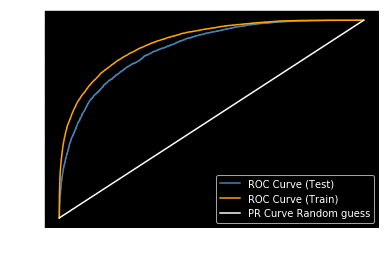

In [28]:
plt.figure()
plt.plot(fpr_te,tpr_te,'-',color='steelblue', label="ROC Curve (Test)")
plt.plot(fpr_tr,tpr_tr,'-',color='orange', label="ROC Curve (Train)")
plt.plot([0,1],[0,1],'w-', label='PR Curve Random guess')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

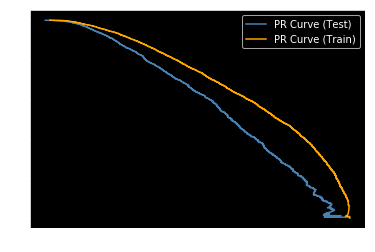

In [29]:
plt.figure()
plt.plot(prec_te,rec_te,'-',color='steelblue', label="PR Curve (Test)")
plt.plot(prec_tr,rec_tr,'-',color='orange', label="PR Curve (Train)")
plt.legend()

In [30]:
print(np.sum(xg_c.feature_importances_ > 0))

618


In [31]:
idx = np.argsort(xg_c.feature_importances_)

In [41]:
lbls = list(np.array(features)[idx][-50:])
print(lbls)

['disposableincome_avgdia75cy', 'householdincome_avghinc_cy', 'gender_pop65_cy', 'unitsinstructure_acsblt2010', 'housingbysize_rnt3pers10', 'store_name_category_02_HUMAN_BEAN', 'agebyracebysex_whtf45_cy', 'store_name_category_04_HUMAN_BEAN', 'store_name_category_03_HUMAN_BEAN', 'proximity_kilometers_03', 'agebyracebysex_whtf50_cy', 'schoolenrollment_acsgrd1', 'householdincome_hinc25_cy', 'store_name_category_02_BLUE_MOON_COFFEE', 'networth_aggnwa45cy', 'agebyracebysex_asnm30_cy', 'networth_aggnwa25cy', 'store_name_category_03_BLUE_MOON_COFFEE', 'store_name_category_01_INDEPENDENT', 'disposableincome_aggdia75cy', 'agebyracebysex_blk60_cy', 'agebyracebysex_blk45_cy', 'store_name_category_02_GAIA_JAVA', 'store_name_category_02_ALLEGRO_COFFEE', 'wealth_avgval_cy', 'store_name_category_03_UNCLE_GARYS_COFFEE_EMPORIUM', 'households_acsfm4pers', 'heatingfuel_acsutlgas', 'agebyracebysex_asnm10_cy', 'networth_aggnw_cy', 'store_name_category_01_STARBUCKS', 'housingcosts_acsaggvalm', 'agebyracebys

Text(0.5,1,'Feature Importance (Weight Importance)')

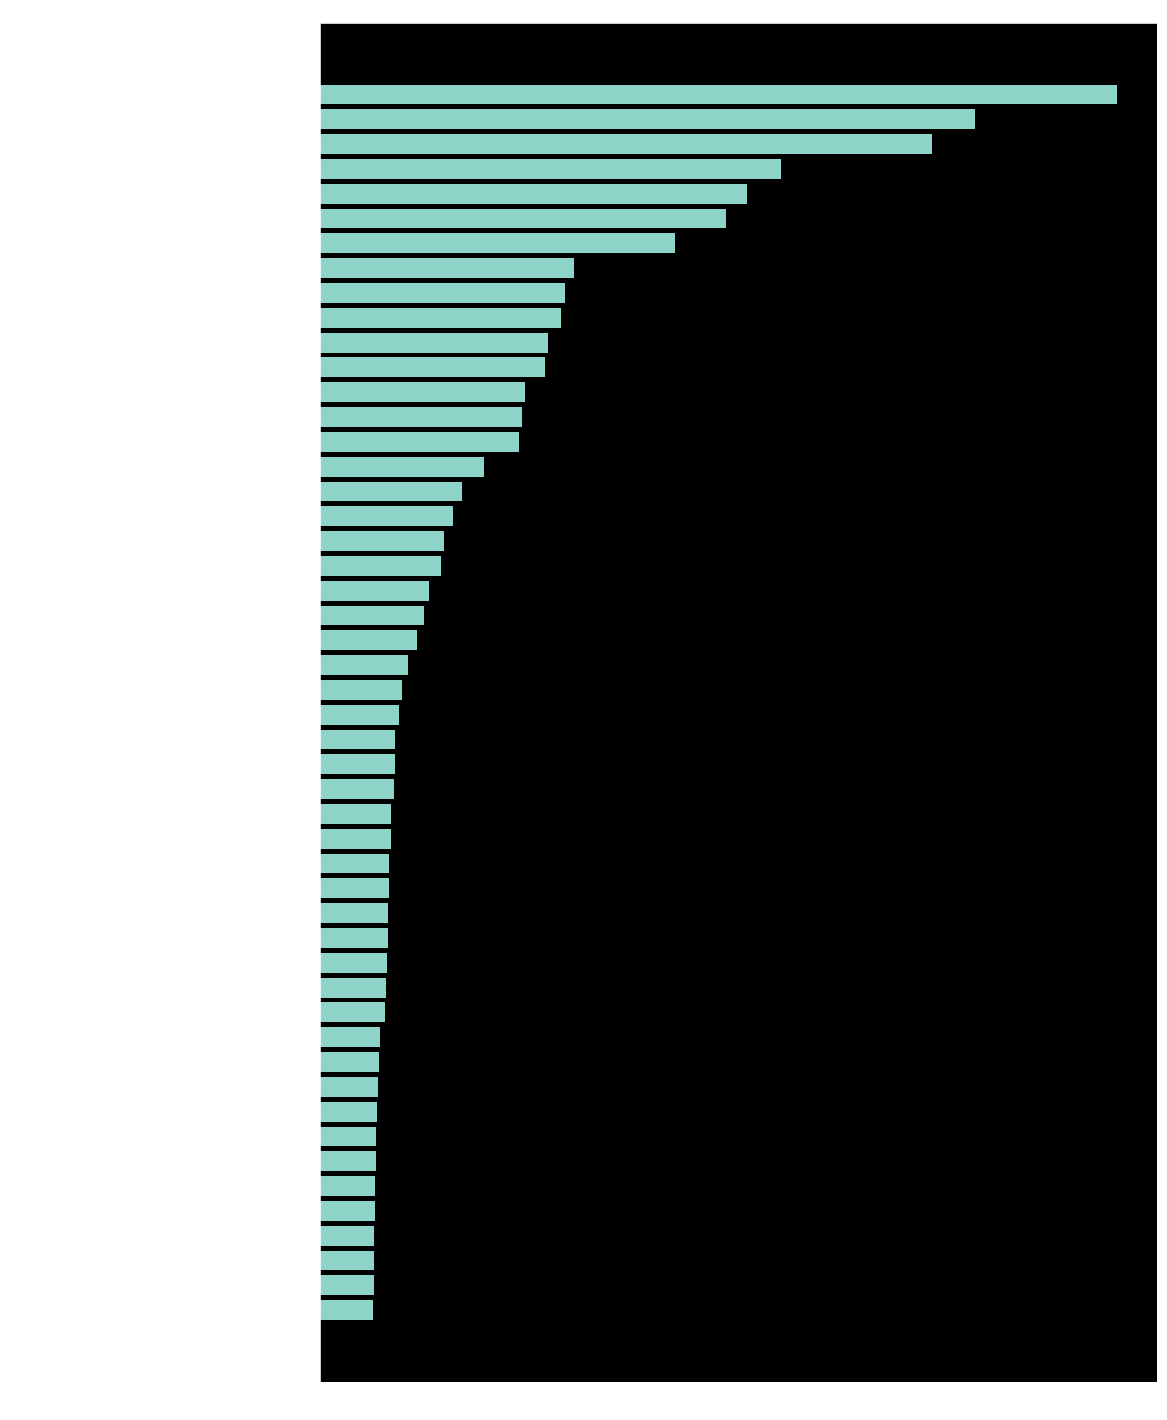

In [49]:
plt.figure(figsize=(15,25))
plt.barh(range(50),xg_c.feature_importances_[idx][-50:])
_ =plt.yticks(range(50), list(np.array(features)[idx][-50:]))
plt.xlabel("Feature Importance (Weight Importance)")
plt.title("Feature Importance (Weight Importance)")

<BarContainer object of 100 artists>

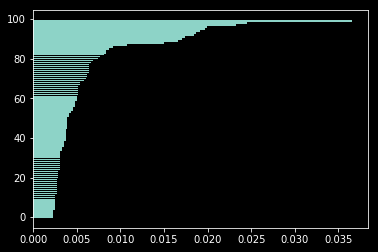

In [725]:
xg_r = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.1).fit(X_train_r, y_train_r, eval_set=[(X_test_r, y_test_r)],eval_metric='rmse',early_stopping_rounds=20)

[0]	validation_0-rmse:0.441388
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.414422
[2]	validation_0-rmse:0.390893
[3]	validation_0-rmse:0.370843
[4]	validation_0-rmse:0.353404
[5]	validation_0-rmse:0.33845
[6]	validation_0-rmse:0.325733
[7]	validation_0-rmse:0.315006
[8]	validation_0-rmse:0.305801
[9]	validation_0-rmse:0.298293
[10]	validation_0-rmse:0.291915
[11]	validation_0-rmse:0.286407
[12]	validation_0-rmse:0.281789
[13]	validation_0-rmse:0.277889
[14]	validation_0-rmse:0.274582
[15]	validation_0-rmse:0.271853
[16]	validation_0-rmse:0.269417
[17]	validation_0-rmse:0.26745
[18]	validation_0-rmse:0.265815
[19]	validation_0-rmse:0.264275
[20]	validation_0-rmse:0.263042
[21]	validation_0-rmse:0.261954
[22]	validation_0-rmse:0.261065
[23]	validation_0-rmse:0.260145
[24]	validation_0-rmse:0.259477
[25]	validation_0-rmse:0.258826
[26]	validation_0-rmse:0.25817
[27]	validation_0-rmse:0.257554
[28]	validation_0-rmse:0.257145
[29]	validation_0-rm

In [726]:
# Regression values
yp_test_r = xg_r.predict(X_test_r)
yp_train_r = xg_r.predict(X_train_r)

In [734]:
print(r2_score(y_test_r, yp_test_r))
print(r2_score(y_train_r, yp_train_r))

0.4401106789626861
0.5629351401710925


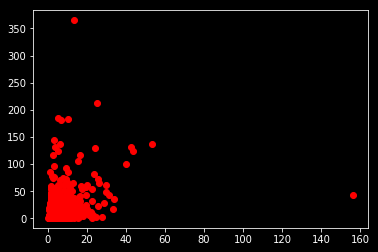

In [732]:
plt.scatter(10**yp_test_r, 10**y_test_r, color='r')

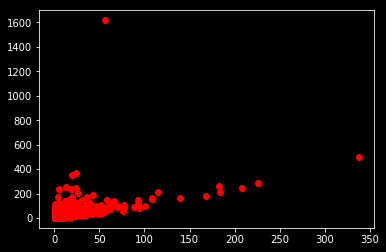

In [731]:
plt.scatter(10**yp_train_r, 10**y_train_r, color='r')

([<matplotlib.axis.YTick at 0x7fef371c3a20>,
 <a list of 50 Text yticklabel objects>)

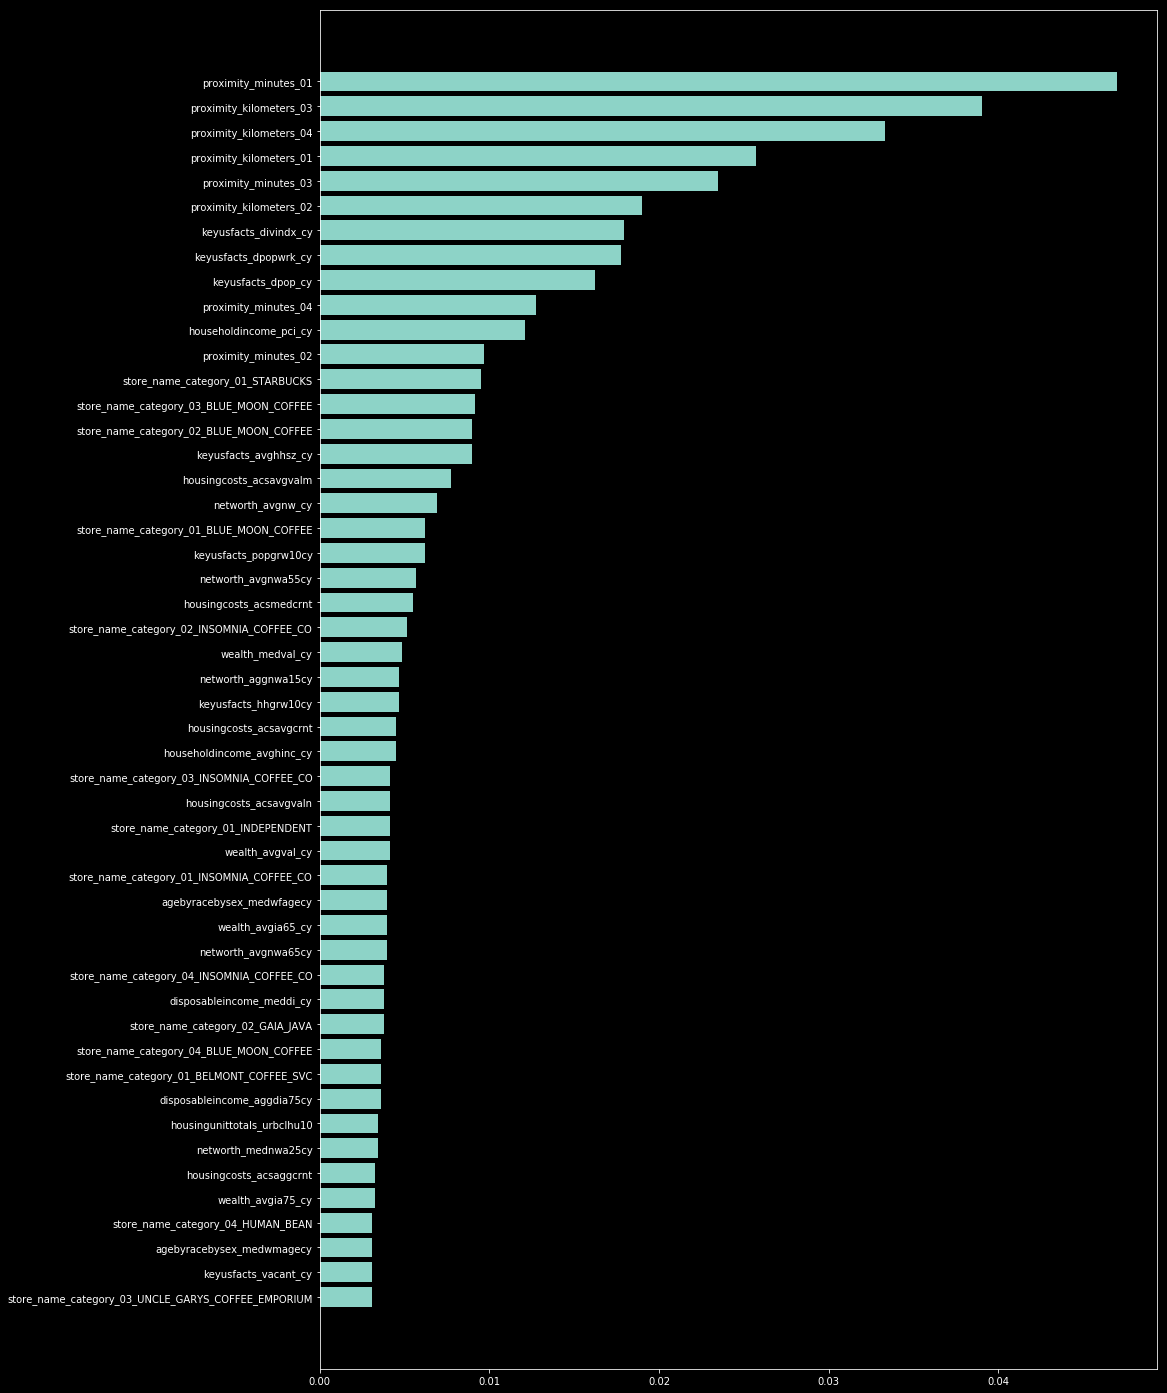

In [760]:
idxr = np.argsort(xg_r.feature_importances_)

plt.figure(figsize=(15,25))
plt.barh(range(50),xg_r.feature_importances_[idxr][-50:])
plt.yticks(range(50),labels=list(np.array(features)[idx][-50:]))